# Neural Machine Translation - ENG/FRN

In this notebook, I will be exploring Machine Translation using RNN. I will be training the model to learn ENG->FRN sentence pairs from the dataset containing sentences in both English and French. Once trained, model will accept English and translate to French. This project is inspired by my current knowledge of the French language, as I have studied French since the 6th grade in school and stopped at my sophomore year of college. I still know a lot, and such as my programming skills, I practice my French skills time to time to stay practiced and not lose my skill.

### Imports & Data

In [1]:
import collections
from collections import Counter
import helper
import os

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import LSTM, RepeatVector, Activation, TimeDistributed, Dense,  Input, GRU, Bidirectional
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam


import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from tabulate import tabulate
import gc

2024-06-20 18:50:56.443907: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# load data
data = pd.read_csv('eng_fr.csv')

### Exploratory Data Analysis

In [3]:
data.head(7)

English words/sentences French words/sentences
0                     Hi.                 Salut!
1                    Run!                Cours !
2                    Run!               Courez !
3                    Who?                  Qui ?
4                    Wow!             Ça alors !
5                   Fire!               Au feu !
6                   Help!             À l'aide !

In [4]:
data.shape

(175621, 2)

In [5]:
#check for missing values
data.isna().sum()
# no missing values

English words/sentences    0
French words/sentences     0
dtype: int64

In [6]:
data = data.rename(columns = {'English words/sentences':'Eng', "French words/sentences":"Frn" })
data.head(2)                           

Eng      Frn
0   Hi.   Salut!
1  Run!  Cours !

In [7]:
# Pick a random sentence from the dataset to inspect
sen = np.random.randint(1, data.shape[0])
print("-- Random English -> French Sentence Pair --\n"
      "English:", data.Eng[sen], "\n"
        "French:", data.Frn[sen])

-- Random English -> French Sentence Pair --
English: These objects are very useful. 
French: Ces objets sont très utiles.


In [8]:
def word_count(txt):
    return len(txt.split())

# apply the function to the English and French columns
data['Eng_Count'] = data['Eng'].apply(lambda x: word_count(x))
data['Frn_Count'] = data['Frn'].apply(lambda x: word_count(x))

# print word counts
print("English Words Count:", data['Eng_Count'].sum())
print("French Words Count:", data['Frn_Count'].sum())

English Words Count: 1082098
French Words Count: 1177832


In [9]:
# figures
fig = make_subplots(rows=1, cols=2, subplot_titles=("English Words Count", "French Words Count"))

fig.add_trace(go.Histogram(x=data['Eng_Count'], histfunc = 'sum', opacity = 0.7, showlegend = False, name='English Words Count'), row=1, col=1)
fig.add_trace(go.Histogram(x=data['Frn_Count'], histfunc = 'sum', opacity = 0.7, showlegend = False, name='French Words Count'), row=1, col=2)

fig.update_layout(height = 600, width = 1500, title_text="Word Count in English and French Sentences")
fig.show()

### Pre-Processing
**Tokenization -** To get a neural network to predict given textual data, it needs to be turned into data it can understand. The input data needs to be numerical, and to do that I will be using Tokenizer.

In [10]:
# Tokenize function
def tokenize(x):
    x_tok = Tokenizer(char_level = False)
    x_tok.fit_on_texts(x)
    return x_tok.texts_to_sequences(x), x_tok

# Padding function to pad the sequences to the same length
def pad(x, length = None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')

### Vocab Size + Seq Len

In [11]:
# Tokenize English and determine Eng Vocab Size
eng_seq, eng_tok = tokenize(data['Eng'])
eng_vocab_size = len(eng_tok.word_index) + 1
print("English Vocabulary Size:", eng_vocab_size)

# Tokenize French sentences and determine Frn Vocab Size
frn_seq, frn_tok = tokenize(data['Frn'])
frn_vocab_size = len(frn_tok.word_index) + 1
print("French Vocabulary Size:", frn_vocab_size)

# DO NOT RUN FOR TEST TWO

English Vocabulary Size: 14532
French Vocabulary Size: 30661


In [10]:
# seq length
eng_len = max([len(sentence) for sentence in eng_seq])
frn_len = max([len(sentence) for sentence in frn_seq])

print("English Sequence Length:", eng_len)
print("French Sequence Length:", frn_len)

NameError: name 'eng_seq' is not defined

### Getting Data Ready for Training/Testing

In [11]:
# Data Split
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 0)

In [12]:
#Dropping columns that are not needed + index reset
train_data = train_data.drop(columns = ['Eng_Count', 'Frn_Count'], axis = 1)
test_data = test_data.drop(columns = ['Eng_Count', 'Frn_Count'], axis = 1)

train_data = train_data.reset_index(drop = True)
test_data = test_data.reset_index(drop = True)

### Processing Data
**English sentences are the features and French sentences are targets**

In [13]:
# TEST TWO

tokenizer_eng = Tokenizer()
tokenizer_eng.fit_on_texts(train_data['Eng'])
train_X_seq = tokenizer_eng.texts_to_sequences(train_data['Eng'])
test_X_seq = tokenizer_eng.texts_to_sequences(test_data['Eng'])

tokenizer_fr = Tokenizer()
tokenizer_fr.fit_on_texts(train_data['Frn'])
train_Y_seq = tokenizer_fr.texts_to_sequences(train_data['Frn'])
test_Y_seq = tokenizer_fr.texts_to_sequences(test_data['Frn'])

# Padding TEST TWO
max_length_eng = max(len(seq) for seq in train_X_seq)
max_length_fr = max(len(seq) for seq in train_Y_seq)

train_X_seq = pad_sequences(train_X_seq, maxlen=max_length_eng, padding='post')
train_Y_seq = pad_sequences(train_Y_seq, maxlen=max_length_fr, padding='post')
test_X_seq = pad_sequences(test_X_seq, maxlen=max_length_eng, padding='post')
test_Y_seq = pad_sequences(test_Y_seq, maxlen=max_length_fr, padding='post')

In [14]:
# TEST TWO
eng_vocab_size = len(tokenizer_eng.word_index) + 1
fr_vocab_size = len(tokenizer_fr.word_index) + 1


In [15]:
# Train Data
train_X_seq, train_X_tok = tokenize(train_data['Eng'])
train_Y_seq, train_Y_tok = tokenize(train_data['Frn'])

train_eng_vocab = len(train_X_tok.word_index) + 1
train_frn_vocab = len(train_Y_tok.word_index) + 1

# Test Data
test_X_seq, test_X_tok = tokenize(test_data['Eng'])
test_Y_seq, test_Y_tok = tokenize(test_data['Frn'])

test_eng_vocab = len(test_X_tok.word_index) + 1
test_frn_vocab = len(test_Y_tok.word_index) + 1

# Padding
train_X_seq = pad(train_X_seq)
train_Y_seq = pad(train_Y_seq)

test_X_seq = pad(test_X_seq)
test_Y_seq = pad(test_Y_seq)

NameError: name 'tokenize' is not defined

In [16]:
table = [["Train Data", train_eng_vocab, train_frn_vocab], ["Test Data", test_eng_vocab, test_frn_vocab]]
print(tabulate(table, headers = ["Data", "English Vocab Size", "French Vocab Size"], tablefmt = "pretty"))

NameError: name 'train_eng_vocab' is not defined

In [ ]:
table = [["Train Data", eng_vocab_size, frn_vocab_size], ["Test Data", test_eng_vocab, test_frn_vocab]]
print(tabulate(table, headers = ["Data", "English Vocab Size", "French Vocab Size"], tablefmt = "pretty"))

### Building Model

##### RNN with Word Embedding
##### Architecture - LSTM

In [17]:
# TEST TWO
def define_model(in_vocab, out_vocab, in_time, out_time, batch_size):
    model = Sequential()
    model.add(Embedding(in_vocab, 256, input_length=in_time, mask_zero=True))  # Increased embedding size
    model.add(LSTM(256, return_sequences=False))
    model.add(RepeatVector(out_time))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))
    return model

In [17]:
# defining model

def define_model(in_vocab, out_vocab, in_time, out_time, batch_size):
    model = Sequential()
    model.add(Embedding(in_vocab, batch_size, input_length = in_time, mask_zero = True))
    model.add(LSTM(batch_size))
    model.add(RepeatVector(out_time))
    model.add(LSTM(batch_size, return_sequences = True))
    model.add(Dense(out_vocab, activation = 'softmax')) # transforms raw outputs into data that is easier to interpret
    
    return model


In [20]:
# Params
b_size = 64
lr = 1e-3 # learning rate

# Model
model = define_model(eng_vocab_size, frn_vocab_size, eng_len, frn_len, b_size)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(lr))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



### Model Training

ModelCheckpoint() Function used to save the model with lowest validation loss.

In [21]:
fn = 'model.keras'
epoch = 2
val_split = 0.1

# Checkpoint
checkpoint = ModelCheckpoint(fn, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min') #monitors the validation loss

# Train

history = model.fit(train_X_seq, train_Y_seq, epochs = epoch, batch_size = b_size, validation_split = val_split, callbacks = [checkpoint], verbose = 1)
# 85 minutes to run!

Epoch 1/2
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.9368
Epoch 1: val_loss improved from inf to 0.82036, saving model to model.keras
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 2595s 1s/step - loss: 1.9363 - val_loss: 0.8204
Epoch 2/2
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.8153
Epoch 2: val_loss improved from 0.82036 to 0.78788, saving model to model.keras
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 2545s 1s/step - loss: 0.8153 - val_loss: 0.7879


In [20]:
# TEST TWO
# Model Compilation and Training
model = define_model(eng_vocab_size, fr_vocab_size, max_length_eng, max_length_fr, 64)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-3))

# Training with Checkpoint
checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, mode='min')
history = model.fit(train_X_seq, train_Y_seq, epochs=5, batch_size=64, validation_split=0.1, callbacks=[checkpoint], verbose=1)

# one epock takes about 3 hours to run, test on more powerful machine

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Epoch 1/5
  66/1976 ━━━━━━━━━━━━━━━━━━━━ 3:22:22 6s/step - loss: 5.9818

KeyboardInterrupt: 

In [ ]:
# TEST TWO
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'])
plt.title('Train vs Validation - Loss')
plt.show()

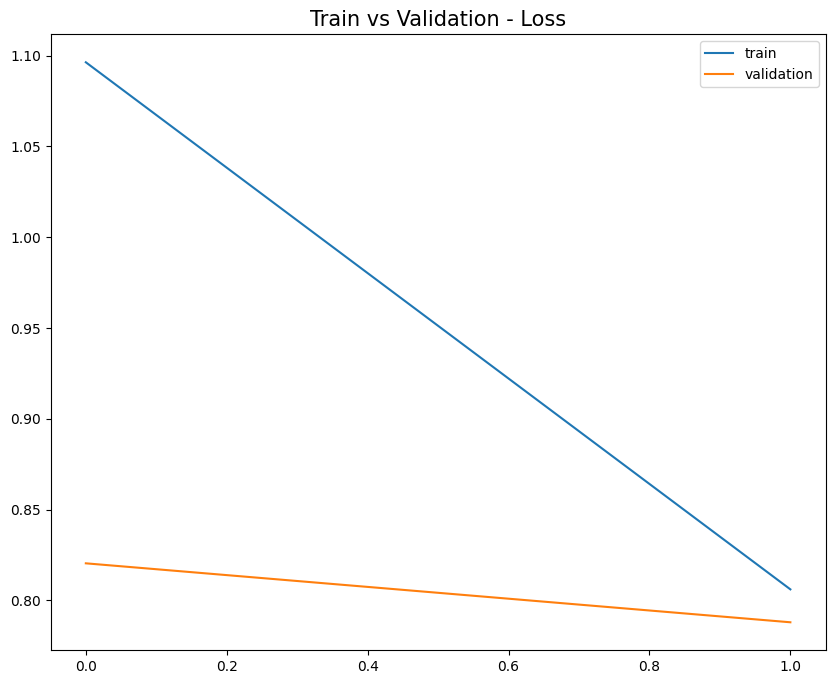

In [22]:
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.title("Train vs Validation - Loss", fontsize=15)
plt.show()

In [ ]:
# TEST TWO RUN AFTER ALL CELLS AND CHANGE EXAMPLE SENTENCE TO CONFIRM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Define a function to preprocess the input sentence
def preprocess_sentence(sentence, tokenizer, max_length):
    tokens = tokenizer.texts_to_sequences([sentence])
    padded_tokens = pad_sequences(tokens, maxlen=max_length, padding='post')
    return padded_tokens

# Define a function to translate the sentence
def translate_sentence(sentence, model, tokenizer_eng, tokenizer_fr, max_length_eng, max_length_fr):
    preprocessed_sentence = preprocess_sentence(sentence, tokenizer_eng, max_length_eng)
    predictions = model.predict(preprocessed_sentence)
    predicted_indices = predictions.argmax(axis=-1)[0]
    translated_sentence = ' '.join([tokenizer_fr.index_word.get(idx, '') for idx in predicted_indices if idx != 0])
    return translated_sentence

# Load the trained model
model_path = "/mnt/data/model.keras"
model = load_model(model_path)

# Assume tokenizer_eng and tokenizer_fr are saved; you can load them or recreate them
# Example: tokenizer_eng = ...  # Load or define tokenizer for English
# Example: tokenizer_fr = ...  # Load or define tokenizer for French
# Define max sequence lengths based on training
max_length_eng = 10  # Adjust as per your dataset
max_length_fr = 10  # Adjust as per your dataset

# Example usage
english_sentence = "Hi."
french_translation = translate_sentence(english_sentence, model, tokenizer_eng, tokenizer_fr, max_length_eng, max_length_fr)
print(f"English: {english_sentence}\nFrench: {french_translation}")
